In [1]:
!wget -nc http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip

File ‘spa-eng.zip’ already there; not retrieving.



In [2]:
!unzip -nq spa-eng.zip

In [3]:
!ls

sample_data  spa-eng  spa-eng.zip


In [4]:
!ls spa-eng

_about.txt  spa.txt


In [5]:
!head spa-eng/spa.txt

Go.	Ve.
Go.	Vete.
Go.	Vaya.
Go.	Váyase.
Hi.	Hola.
Run!	¡Corre!
Run.	Corred.
Who?	¿Quién?
Fire!	¡Fuego!
Fire!	¡Incendio!


In [6]:
# compile eng-spa translations
eng2spa = {}
for line in open('spa-eng/spa.txt'):
    line = line.rstrip()
    eng, spa = line.split('\t')
    if eng not in eng2spa:
        eng2spa[eng] = []
    eng2spa[eng].append(spa)    

In [7]:
eng2spa

{'Go.': ['Ve.', 'Vete.', 'Vaya.', 'Váyase.'],
 'Hi.': ['Hola.'],
 'Run!': ['¡Corre!'],
 'Run.': ['Corred.'],
 'Who?': ['¿Quién?'],
 'Fire!': ['¡Fuego!', '¡Incendio!', '¡Disparad!'],
 'Help!': ['¡Ayuda!', '¡Socorro! ¡Auxilio!', '¡Auxilio!'],
 'Jump!': ['¡Salta!'],
 'Jump.': ['Salte.'],
 'Stop!': ['¡Parad!', '¡Para!', '¡Pare!'],
 'Wait!': ['¡Espera!'],
 'Wait.': ['Esperen.'],
 'Go on.': ['Continúa.', 'Continúe.'],
 'Hello!': ['Hola.'],
 'I ran.': ['Corrí.', 'Corría.'],
 'I try.': ['Lo intento.'],
 'I won!': ['¡He ganado!'],
 'Oh no!': ['¡Oh, no!'],
 'Relax.': ['Tomátelo con soda.'],
 'Smile.': ['Sonríe.'],
 'Attack!': ['¡Al ataque!', '¡Atacad!'],
 'Get up.': ['Levanta.'],
 'Go now.': ['Ve ahora mismo.'],
 'Got it!': ['¡Lo tengo!'],
 'Got it?': ['¿Lo pillas?', '¿Entendiste?'],
 'He ran.': ['Él corrió.'],
 'Hop in.': ['Métete adentro.'],
 'Hug me.': ['Abrázame.'],
 'I fell.': ['Me caí.'],
 'I know.': ['Yo lo sé.'],
 'I left.': ['Salí.'],
 'I lied.': ['Mentí.'],
 'I lost.': ['Perdí.'],
 'I 

In [8]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

In [9]:
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')

In [10]:
tokenizer.tokenize("¿Qué me cuentas?".lower())

['qué', 'me', 'cuentas']

In [29]:
smoother = SmoothingFunction()
tokens = tokenizer.tokenize("¿Qué me cuentas?".lower())
sentence_bleu([tokens], tokens, smoothing_function=smoother.method4)

0.5757197301274735

In [30]:
sentence_bleu([['hi']], ['hi'], smoothing_function=smoother.method4)

1.0

In [31]:
sentence_bleu(['hi there'.split()], 'hi there'.split(),
              smoothing_function=smoother.method4)

0.2213885886251307

In [36]:
sentence_bleu(['hi there friend'.split()], 'hi there friend'.split(),
              smoothing_function=smoother.method4)

0.5757197301274735

In [38]:
sentence_bleu([[1, 2, 3, 4]], [1, 2, 3, 4])

1.0

In [41]:
eng2spa_tokens = {}
for eng, spa_list in eng2spa.items():
    spa_list_tokens = []
    for text in spa_list:
        tokens = tokenizer.tokenize(text.lower())
        spa_list_tokens.append(tokens)
    eng2spa_tokens[eng] = spa_list_tokens

In [42]:
!pip install transformers sentencepiece transformers[sentencepiece]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 5.0 MB/s 
     |████████████████████████████████| 1.3 MB 67.3 MB/s 
     |████████████████████████████████| 7.6 MB 35.1 MB/s 
     |████████████████████████████████| 182 kB 56.2 MB/s 


In [43]:
from transformers import pipeline
translator = pipeline('translation', model = "Helsinki-NLP/opus-mt-en-es")

Downloading:   0%|          | 0.00/1.47k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/312M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/44.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/802k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/826k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.59M [00:00<?, ?B/s]

/usr/local/lib/python3.8/dist-packages/transformers/models/marian/tokenization_marian.py:194: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


In [44]:
translator("I like eggs and ham")

[{'translation_text': 'Me gustan los huevos y el jamón.'}]

In [45]:
eng_phrases = list(eng2spa.keys())
len(eng_phrases)

102904

In [52]:
eng_phrases_subset = eng_phrases[20_000:20_100]

In [53]:
translations = translator(eng_phrases_subset)

In [58]:
translations[0]

{'translation_text': 'Tom está en el jardín.'}

In [56]:
scores = []
for eng, pred in zip(eng_phrases_subset, translations):
    matches = eng2spa_tokens[eng]

    # tokenize translation
    spa_pred = tokenizer.tokenize(pred['translation_text'].lower())

    score = sentence_bleu(matches, spa_pred,
                          smoothing_function=smoother.method4)
    scores.append(score)

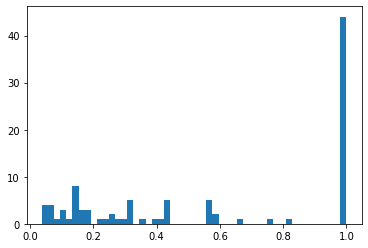

In [57]:
import matplotlib.pyplot as plt
plt.hist(scores, bins=50);

In [59]:
import numpy as np
np.mean(scores)

0.5990809099501675

In [70]:
np.random.seed(1)

def print_random_translation():
    i = np.random.choice(len(eng_phrases_subset))
    eng = eng_phrases_subset[i]
    print("EN:", eng)

    translation = translations[i]['translation_text']
    print("ES translation:", translation)

    matches = eng2spa[eng]
    print("Matches:", matches)

In [71]:
print_random_translation()

EN: Tom isn't that young.
ES translation: Tom no es tan joven.
Matches: ['Tom no es tan joven.']


In [72]:
print_random_translation()

EN: Tom is proud of Mary.
ES translation: Tom está orgulloso de María.
Matches: ['Tom está orgulloso de Mary.']


In [73]:
print_random_translation()

EN: Tom must be Canadian.
ES translation: Tom debe ser canadiense.
Matches: ['Tom tiene que ser canadiense.']


In [74]:
print_random_translation()

EN: Tom is old-fashioned.
ES translation: Tom es anticuado.
Matches: ['Tom es anticuado.']


END